
.
<h1 style="color:#2bf0b5;"> <b>Neuroscience</b> HW1-1 - Lachin Naghashyar</h1>

---

<h2 style="color:#f06ff2;"> <b>Hodgkin-Huxley model</b></h2>

It is a mathematical model that describes how action potentials in neurons are initiated and propagated. I implemented this model in python based on the equations it has.
\begin{aligned}
-C_{m} \frac{d v}{d t}=g_{m}\left(v-E_{L}\right)+g_{k} n^{4}\left(v-E_{K}\right)+g_{N a} m^{3} h\left(v-E_{N a}\right)-I_{\text {ext }} \\
\end{aligned}
\begin{aligned}
\tau_{n} \frac{d n}{d t} &=-n+n_{\infty} \\
\tau_{m} \frac{d m}{d t} &=-m+m_{\infty} \\
\tau_{h} \frac{d h}{d t} &=-h+h_{\infty}
\end{aligned}
First I started by defining some constants:



In [3]:
import numpy as np
import matplotlib.pyplot as plt
# constants:
dt = 0.01  # Simulation time step
Duration = 200  # Simulation length
T = int(np.ceil(Duration / dt))
t = np.arange(1, T + 1) * dt  # Simulation time points in ms
Cm = 1  # Membrane capacitance in micro Farads
gNa = 120  # in Siemens, maximum conductivity of Na+ Channel
gK = 36  # in Siemens, maximum conductivity of K+ Channel
gl = 0.3  # in Siemens, conductivity of leak Channel
ENa = 55  # in mv, Na+ nernst potential
EK = -72  # in mv, K+ nernst potential
El = -49.4  # in mv, nernst potential for leak channel
vRest = -60  # in mv, resting potential
V = vRest * np.ones(T)  # Vector of output voltage

**Q1:** Next, I was asked to plot the time constants and steady states of n, m and h. For doing so, I started by calculating the 
$ \alpha_i $ and $\beta_i$s:


In [4]:
def alpha_n(v): return ((0.1 * (-v + vRest) + 1) / 10) / (np.exp(1 + 0.1 * (-v + vRest)) - 1)


def beta_n(v): return 0.125 * np.exp((-v + vRest) / 80)


def alpha_m(v): return (((-v + vRest) + 25) / 10) / (np.exp(2.5 + 0.1 * (-v + vRest)) - 1)


def beta_m(v): return 4 * np.exp((-v + vRest) / 18)


def alpha_h(v): return 0.07 * np.exp((-v + vRest) / 20)


def beta_h(v): return 1 / (1 + np.exp(3 + 0.1 * (-v + vRest)))

Now let's use the formulas for calculating $\tau$ and steady states:
$$
\begin{array}{ll}
\tau_{n}(V) \frac{d n}{d t}=n_{\infty}(V)-n & \tau_{m}(V)=\frac{1}{\alpha_{n}(V)+\beta_{n}(V)}, n_{\infty}(V)=\frac{\alpha_{n}(V)}{\alpha_{n}(V)+\beta_{n}(V)} \\
\tau_{m}(V) \frac{d m}{d t}=m_{\infty}(V)-m & \tau_{m}(V)=\frac{1}{\alpha_{m}(V)+\beta_{m}(V)}, m_{\infty}(V)=\frac{\alpha_{m}(V)}{\alpha_{m}(V)+\beta_{m}(V)} \\
\tau_{h}(V) \frac{d h}{d t}=h_{\infty}(V)-h & \tau_{h}(V)=\frac{1}{\alpha_{h}(V)+\beta_{h}(V)}, h_{\infty}(V)=\frac{\alpha_{h}(V)}{\alpha_{h}(V)+\beta_{h}(V)}
\end{array}
$$

In [5]:
vt = np.arange(-80, 10, 0.01)
time_cons_n = 1 / (alpha_n(vt) + beta_n(vt))
time_cons_m = 1 / (alpha_m(vt) + beta_m(vt))
time_cons_h = 1 / (alpha_h(vt) + beta_h(vt))

steady_state_n = alpha_n(vt) / (alpha_n(vt) + beta_n(vt))
steady_state_m = alpha_m(vt) / (alpha_m(vt) + beta_m(vt))
steady_state_h = alpha_h(vt) / (alpha_h(vt) + beta_h(vt))

And plot them:

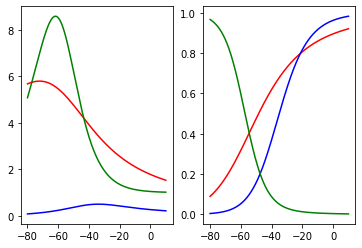

In [6]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(vt, time_cons_n, 'r')
ax[0].plot(vt, time_cons_m, 'b')
ax[0].plot(vt, time_cons_h, 'g')

ax[1].plot(vt, steady_state_n, 'r')
ax[1].plot(vt, steady_state_m, 'b')
ax[1].plot(vt, steady_state_h, 'g')
plt.show()

We can compare the time constants which change based on $V$, for each of the channels in the first figure. The time
constant ($\tau$) shows the amount of time it takes for the change in potential and how much the system is fast.
Hence, since the sodium channel has a smaller $\tau$,
it opens first and $m_{\infty}$ (probability of each sodium sub-unit being open) starts to increase with the voltage.
After a while (with $\tau_h$ being larger), the gate which blocks the sodium channels starts to get activated.
This way, $h_{\infty}$ (probability of sodium channel being not closed) starts to decrease from one to zero exponentially.
We know that the probability of sodium channel being active is $m^3 h$ and when $h$ reaches zero, the sodium channels
become inactive. (this process results in depolarization which is a rapid increase in voltage and then slowing)

Since $\tau_m < \tau_n$, the potassium channels get activated after the sodium channels. Similarly,
$n_{\infty}$ (probability of each potassium sub-unit being open) starts to increase with the voltage and this lets $K^+$ s
in. Also given that $m_{\infty} < n_{\infty}$, it reaches to a higher probability as $V$ grows. (this process results in
hyper polarization which causes the voltage to decrease).

**Q2:** Now, in order to implement those differential equations, I used Euler method which simply computes $dm$, $dn$, $dh$ and $dv$ in each step and uses formulas mentioned above to  update $m$, $n$, $h$ and $v$ values which are defined as arrays. This is what I did in plot_model function. 

In [7]:
def HH_model(I):
    n, m, h = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))
    n[0], m[0], h[0] = alpha_n(V[0]) / (alpha_n(V[0]) + beta_n(V[0])), alpha_m(V[0]) / (
            alpha_m(V[0]) + beta_m(V[0])), alpha_h(V[0]) / (
                               alpha_h(V[0]) + beta_h(V[0]))

    for i in range(1, len(t)):
        m[i] = m[i - 1] + dt * (alpha_m(V[i - 1]) * (1 - m[i - 1]) - beta_m(V[i - 1]) * m[i - 1])
        n[i] = n[i - 1] + dt * (alpha_n(V[i - 1]) * (1 - n[i - 1]) - beta_n(V[i - 1]) * n[i - 1])
        h[i] = h[i - 1] + dt * (alpha_h(V[i - 1]) * (1 - h[i - 1]) - beta_h(V[i - 1]) * h[i - 1])

        I_L = gl * (V[i - 1] - El)
        I_K = (gK * np.power(n[i - 1], 4)) * (V[i - 1] - EK)
        I_Na = (gNa * h[i - 1] * np.power(m[i - 1], 3)) * (V[i - 1] - ENa)

        V[i] = V[i - 1] + dt * ((-1 / Cm) * (I_L + I_K + I_Na - I[i - 1]))

    return n, m, h, V


def plot_model(I):
    n, m, h, V = HH_model(I)
    plt.plot(t, I, 'orange')
    plt.plot(t, V)
    plt.show()



Aslo for the external stimulus, I started by applying a constant stimuli of 10 uA to almost the whole time interval. Finally we can plot this model and see that the neuron fires many spikes for this stimuli.

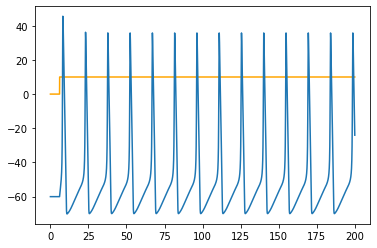

In [8]:
def plot_for_constant_I(c):
    I = np.zeros(T) # in uA, external stimulus (external current)
    I[600:T] = c
    plot_model(I)


plot_for_constant_I(10)

**Q3:** To find the minimum amount of external stimuli in which neuron spikes, I started by generating different currents and see the neuron's behaviour:

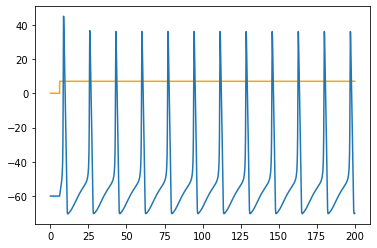

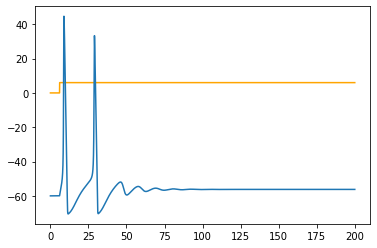

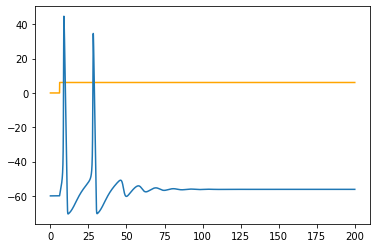

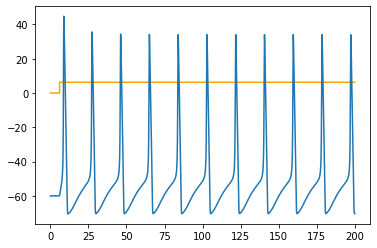

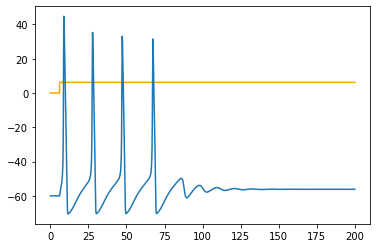

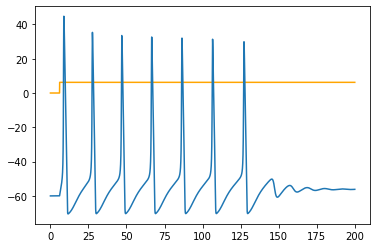

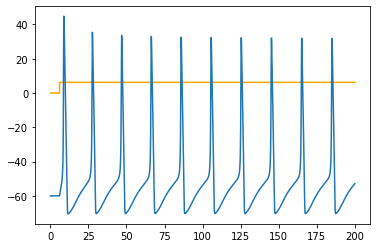

In [9]:
plot_for_constant_I(7)
plot_for_constant_I(6) # so it should be between 6 and 7
plot_for_constant_I(6.1)
plot_for_constant_I(6.3) # it should be between 6.1 and 6.3
plot_for_constant_I(6.2)
plot_for_constant_I(6.22)
plot_for_constant_I(6.23)

So it is around 6.2 and 6.3, we can go with 6.23.

**Q4:** To find the minimum interval for stimuli, I used the function below and tested it out for some values.

In [10]:
def plot_for_interval_I(c):
    I = np.zeros(T) # in uA, external stimulus (external current)
    I[1000:1000+c] = 6.23
    plot_model(I)

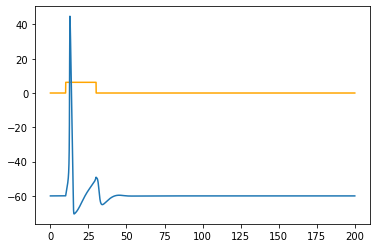

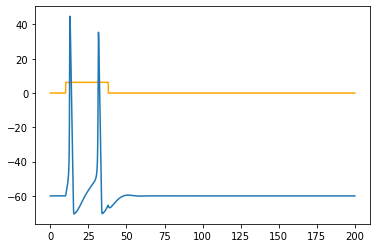

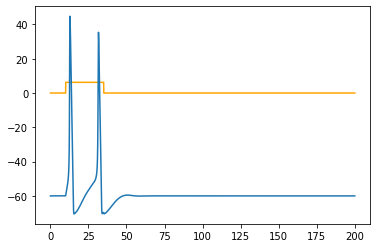

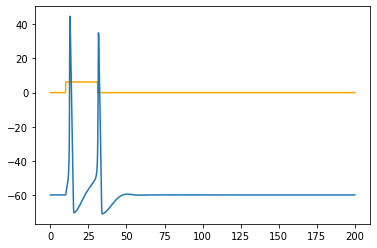

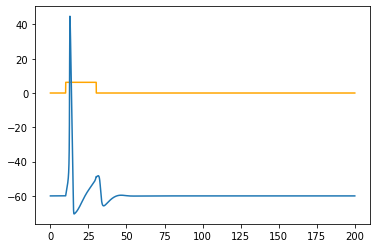

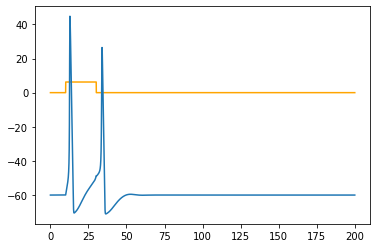

In [11]:
plot_for_interval_I(2000)
plot_for_interval_I(2800)
plot_for_interval_I(2500) # it can be less than 2500
plot_for_interval_I(2100)
plot_for_interval_I(2009)
plot_for_interval_I(2010)

Hence, we can have 2010 as the minimum time interval that neuron fires a spike.

**Q5:** To find the domain and frequency of neuron for different values of $I$, I used the plot_for constant_I function:

<table>
  <tr>
    <th>I</th>
    <th>domain</th>
    <th>frequency</th>
  </tr>
  <tr>
    <td>6.23</td>
    <td>104</td>
    <td>0.05</td>
  </tr>
  <tr>
    <td>6.5</td>
    <td>104</td>
    <td>0.056</td>
  </tr>
  <tr>
    <td>10</td>
    <td>105</td>
    <td>0.067</td>
  </tr>
  <tr>
    <td>20</td>
    <td>100</td>
    <td>0.083</td>
  </tr>
  <tr>
    <td>30</td>
    <td>93</td>
    <td>0.1</td>
  </tr>
  <tr>
    <td>50</td>
    <td>78</td>
    <td>0.11</td>
  </tr>
  <tr>
    <td>60</td>
    <td>71</td>
    <td>0.12</td>
  </tr>
  <tr>
    <td>80</td>
    <td>64</td>
    <td>0.13</td>
  </tr>
  <tr>
    <td>100</td>
    <td>41</td>
    <td>0.15</td>
  </tr>
  <tr>
    <td>111</td>
    <td>35</td>
    <td>0.16</td>
  </tr>
  <tr>
    <td>140</td>
    <td>16</td>
    <td>0.17</td>
  </tr>
</table>

**Q6:** Starting from an external current which is lower than 6 (the lower bound) we won't see any spiking behaviour.
The reason for this is that a small $I$ would only increase the voltage slightly and not to its threshold (-30mV) and
therefore the action potential con not be produced, making the voltage go back to its initial value which was the
resting potential. By continuing to increase the current, we will see that it starts to fire spikes when current
reaches above 6.23 uA in a time interval of 100ms . Meaning, this amount of stimuli is enough for the voltage to
pass the threshold and produce an action potential. We can also see that by making $I$ even larger, the domain starts
to decrease whereas the frequency of spikes start to go up (meaning the action potential gets produced faster).
This behaviour continues until we reach the upper bound for $I$. For the value of the upper-bound, if lower domains are still ideal for us to consider them as a current in which neuron fires spikes we can go with 100 uA but since I am looking for a larger domain, I choose $50$ as my upper bound where the neuron reaches at least 12.5 mV when it spikes.


**Q7:** Let's have $I_1 = -5$ and $I_2 = 160$. Based on the observations above, we know that in this currents, neuron won't fire spikes. But we can plot the spikes in the interval between these two and as we've expected, we start with no spike and then see decent spikes with a larger domain and period. Then they gradually start to become smaller until we don't see the spiking pattern. (We could've also started with a positive current less than 6.23 for $I_1$)

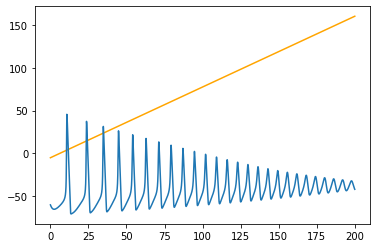

In [12]:
I = np.linspace(-5, 160, T)
plot_model(I)

**Q8:** We can have $I_1 = 2$, $I_2=7$ and $I_3=200$ and plot  n-V, m-V, h-V sub plots.

In [13]:
def plot_subPlots(c):
    I = np.zeros(T)
    I[600:T] = c
    n, m, h, V = HH_model(I)
    plot_model(I)
    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax[0].plot(V, m)
    ax[1].plot(V, n)
    ax[2].plot(V, h)
    plt.show()    

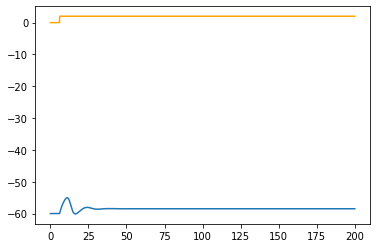

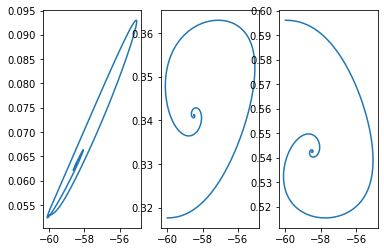

In [14]:
plot_subPlots(2)

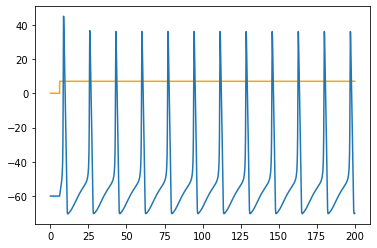

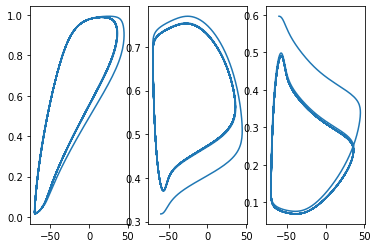

In [15]:
plot_subPlots(7)

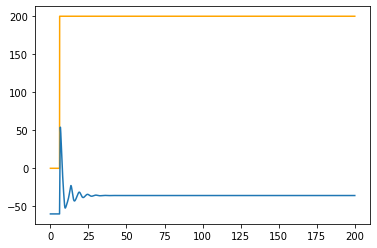

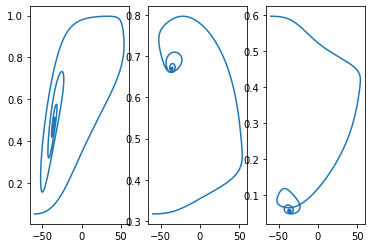

In [16]:
plot_subPlots(200)

As we can see, for a stimuli less than the lower-bound, neuron won't generate spikes. We can also see this in the 
m-V plot that when $V$ starts to go up, $m$ also increases so that the sodium channels start to open and after a 
while the same happens to potassium channel. Next, sodium channel starts to get closed with $h$. Since the stimuli 
is not enough for the voltage to reach its threshold, the next time, $m$ doesn't go up and stays around the same 
initial value. This also happens to $n$ and $h$, and they don't change much either. 

On the other hand, for a stimuli which neuron produces action potential, we can see this behaviour in all the 
channels that they keep their periodic activity (that sodium opens faster when the voltage goes up and gets closed 
when voltage decreases, also potassium opens as well but a bit later and has about the same behaviour. Whereas $h$ 
has the opposite behaviour and goes up when having lower $V$.) 

For a stimuli larger than the upper-bound, we can see that it experiences slight fluctuations at first, but it 
doesn't have the spiking pattern. This is also illustrated in plots. As you can see, the plots have somehow the 
same shape as the middle one but after having a few periods, they stay around the same place and don't get changed 
and triggered. 

**Q9:** This section experiments different types of stimuli pattern on neuron's spiking.

- $I$ as a triangle signal:

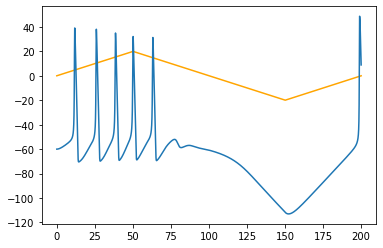

In [17]:
def triangle(length, amplitude):
    section = length // 4
    for direction in (1, -1):
        for i in range(section):
            yield i * (amplitude / section) * direction
        for i in range(section):
            yield (amplitude - (i * (amplitude / section))) * direction


I = np.asarray(list(triangle(T, 20)))
plot_model(I)

- $I$ as a pulse:

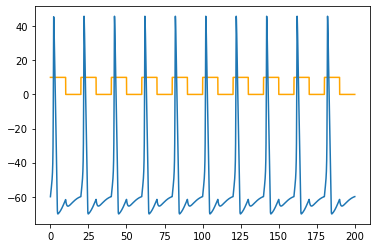

In [18]:
# from scipy import signal
# t = np.linspace(0, Duration, T)
# i = signal.gausspulse(t, fc=5, retquad=True, retenv=True)
# plot_model(i)

sig = (np.arange(T) % 2000 < 1000) * 10
plot_model(sig)

- $I$ as chirp signal:

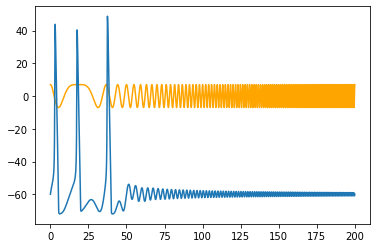

In [19]:
from scipy.signal import chirp
I = chirp(np.linspace(0, Duration, T), f0=0.11, f1=0.05, t1=10, method='linear') * 7
plot_model(I)

- $I$ as a $sin$ signal:

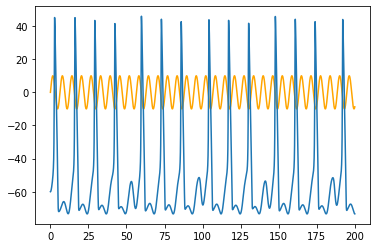

In [20]:
I = np.sin(np.linspace(0, Duration, T)) * 10
plot_model(I)

Which is aligned with our expectations. As you can see, we mostly have the spikes occurring at the peaks of sin function where $I$ is large enough. Also we can see some other similar patterns for different frequencies of $sin$ function below:

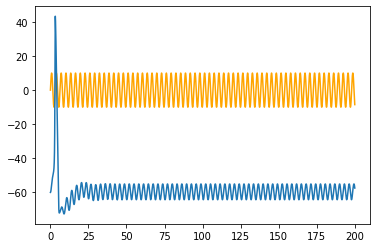

In [21]:
plot_model(np.sin(2 * (np.linspace(0, Duration, T))) * 10)

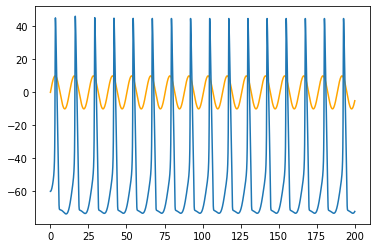

In [22]:
plot_model(np.sin(0.5 * (np.linspace(0, Duration, T))) * 10)

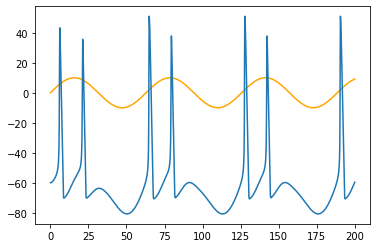

In [23]:
plot_model(np.sin(0.1 * (np.linspace(0, Duration, T))) * 10)

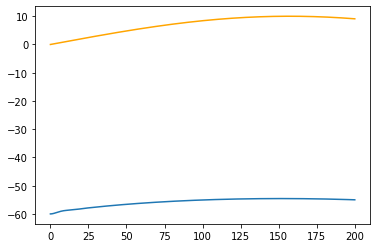

In [24]:
plot_model(np.sin(0.01 * (np.linspace(0, Duration, T))) * 10)

Hence, as the frequency of $sin$ goes up, the frequency of neuron's spiking goes up as well. In very high or very 
low frequencies, neuron is not generating a decent spike. Whereas in frequencies around 1 and 0.1, it has a proper spiking pattern.

**Q10:** We know that firing rate is calculated based on the spikes in a time interval. In order to detect spikes, I used a threshold of 12.5 which is the max voltage for $I=50uA$.:

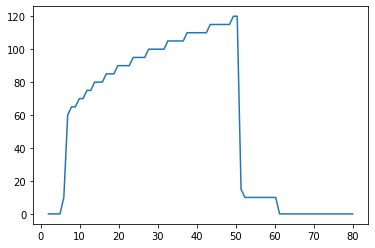

In [32]:
def calc_firing_rate(I, duration):
    n, m, h, V = HH_model(I)
    firing_threshold = 12.5
    spikes = 0
    for i in range(len(V)):
        if V[i] > firing_threshold >= V[i - 1]:
            spikes += 1
    if spikes == 1:
        spikes = 0
    return spikes / (duration / 1000)


I_arr = np.linspace(2, 80, 80)
F = np.zeros(I_arr.shape)
for i in range(80):
    I = np.ones(T) * I_arr[i]
    F[i] = calc_firing_rate(I, Duration)

plt.plot(I_arr, F)
plt.show()

As expected, it doesn't spike in a very low $I$, however, as $I$ goes up, the frequncy and firing rate goes up as well. Unitl it reaches 50 where it doesn't generate that many spikes anymore.